# 02750 HW2 

### Anushka Sinha (anushka3)

#### Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import warnings
import random
from sklearn.model_selection import train_test_split
import math
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# To ignore all warnings:
warnings.filterwarnings('ignore')

#### Data

In [2]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
data = pd.read_csv("iris/iris.data", header=None, names=column_names)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
label_encoder = LabelEncoder()
data['species_encoded'] = label_encoder.fit_transform(data['species'])
data = data.drop(columns=['species'])
data_array = data.to_numpy()

In [3]:
random_seeds = []
for i in range(10):
    random.seed(100*i)
    random_seeds.append(random.randint(1, 100))
random_seeds

[50, 19, 6, 77, 40, 60, 34, 22, 86, 80]

#### Cross fold validation 

In [4]:
def run_cross_fold_validation(model, train_X, train_y, seed):
    
    """ 
    Split your training data at that round into 5 different sets of equal size (or as equal as they can be). 
    Train a model using 4 of the 5 sets. Assess that model on the remaining set. 
    Continue this process until each set has been used for assessment once. 
    Add up the errors from all 5 folds and divide by the total number of observed instances. 
    This will yield an average error that will not be severely biased by imbalances in the fold sizes. 
    This will give you a good estimate of the model performance given the data you have available to you at that round. 
    This will not necessarily give you an estimate of generalization performance
  """
    # Initialize KFold with 5 splits
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    fold_accuracies = []

    for train_idx, test_idx in kf.split(train_X):
        # Split the data into training and testing sets for this fold
        X_train_fold, X_test_fold = train_X[train_idx], train_X[test_idx]
        y_train_fold, y_test_fold = train_y[train_idx], train_y[test_idx]

        # Train a model on the training fold
        model.fit(X_train_fold, y_train_fold)

        # Predict on the testing fold
        y_pred_fold = model.predict(X_test_fold)

        # Calculate accuracy for this fold
        fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)
        fold_accuracies.append(fold_accuracy)  # Store error rate

    # Calculate average error across all folds
    avg_acc = sum(fold_accuracies) / len(fold_accuracies)
    return avg_acc


#### QBC - not mellow

In [5]:
def hard_vote_entropy(pool_X, pool_y, committee_members):
    predictions_pool_X = []
    for model in committee_members:
        y_pred = model.predict(pool_X)
        predictions_pool_X.append(y_pred)
    predictions_pool_X = np.array(predictions_pool_X)
    
    counts_setosa = np.zeros(len(predictions_pool_X[0]), dtype=int)
    counts_versicolor = np.zeros(len(predictions_pool_X[0]), dtype=int)
    counts_virginica = np.zeros(len(predictions_pool_X[0]), dtype=int)
   
   # Prediction counts for different labels 
    for pred in predictions_pool_X:
        for instance, val in enumerate(pred): 
            if val == 0:
                counts_setosa[instance] += 1
            elif val == 1:
                counts_versicolor[instance] += 1   
            elif val == 2:
                counts_virginica[instance] += 1        
    # Return the instance index with the max hard vote entropy score
    HVE_scores = [-1, -math.inf]
    for instance in range(len(counts_setosa)):
        if counts_setosa[instance] != 0:
            first_term = (counts_setosa[instance]/len(committee_members)) * math.log((counts_setosa[instance]/len(committee_members)), 2)
        else:
            first_term = 0
        if counts_versicolor[instance] != 0:
            second_term = (counts_versicolor[instance]/len(committee_members)) * math.log((counts_versicolor[instance]/len(committee_members)), 2)
        else:
            second_term = 0
        if counts_virginica[instance] != 0:
            third_term = (counts_virginica[instance]/len(committee_members)) * math.log((counts_virginica[instance]/len(committee_members)), 2)
        else:
            third_term = 0
        score = -(first_term + second_term + third_term)
        if score > HVE_scores[1]:
            HVE_scores[0] = instance
            HVE_scores[1] = score
    return HVE_scores[0]

def QBC(dataset, seed):
    cross_fold_performance = []

    # Take initial 20% data (random observations)
    sample_data, remaining_data = train_test_split(dataset, test_size=0.8, random_state=seed)
    sample_data_X, sample_data_y = sample_data[:, :4], sample_data[:, 4]  # Slicing first four columns
    remaining_data_X, remaining_data_y = remaining_data[:, :4], remaining_data[:, 4]  # Slicing first four columns

    # Initialize committee members
    committee = [RandomForestClassifier() for _ in range(10)]
    for model in committee:
        model.fit(sample_data_X, sample_data_y)

    base_learner_model = RandomForestClassifier(random_state=None)

    # Run until all observations are added:
    while len(remaining_data) > 0:
        cv_accuracy = run_cross_fold_validation(base_learner_model, sample_data_X, sample_data_y, seed)
        cross_fold_performance.append(cv_accuracy)
    
        # Select an instance to add = hard_vote_entropy()
        instance_to_add = hard_vote_entropy(remaining_data_X, remaining_data_y, committee)

        # Get the data of the instance to add
        instance_X, instance_y = remaining_data_X[instance_to_add], remaining_data_y[instance_to_add]

        # Add the queried instance to the training set
        sample_data_X = np.append(sample_data_X, [instance_X], axis=0)
        sample_data_y = np.append(sample_data_y, [instance_y], axis=0)

        # Remove the queried instance from the pool
        remaining_data = np.delete(remaining_data, instance_to_add, axis=0)
        remaining_data_X, remaining_data_y = remaining_data[:, :4], remaining_data[:, 4]
        
        # Retrain the committee members on the updated training set
        for model in committee:
            model.fit(sample_data_X, sample_data_y)

    return cross_fold_performance

# Running QBC - not mellow
cross_fold_accuracies_QBC = []

for seed in tqdm(random_seeds):
    cv_acc = QBC(data_array, seed)
    cross_fold_accuracies_QBC.append(cv_acc)

avg_acc_QBC = np.mean(cross_fold_accuracies_QBC, axis=0)
std_acc_QBC = np.std(cross_fold_accuracies_QBC, axis=0)
x_values_QBC = list(range(len(cv_acc)))

100%|██████████| 10/10 [17:51<00:00, 107.17s/it]


## Exercsie 2 Query By Committee - Mellow Modality

In [6]:
def hard_vote_entropy_mellow(pool_X, pool_y, committee_members, threshold):
    predictions_pool_X = []
    for model in committee_members:
        y_pred = model.predict(pool_X)
        predictions_pool_X.append(y_pred)
    predictions_pool_X = np.array(predictions_pool_X)
    
    counts_setosa = np.zeros(len(predictions_pool_X[0]), dtype=int)
    counts_versicolor = np.zeros(len(predictions_pool_X[0]), dtype=int)
    counts_virginica = np.zeros(len(predictions_pool_X[0]), dtype=int)
   
   # Prediction counts for different labels
    for pred in predictions_pool_X:
        for instance, val in enumerate(pred): 
            if val == 0:
                counts_setosa[instance] += 1
            elif val == 1:
                counts_versicolor[instance] += 1   
            elif val == 2:
                counts_virginica[instance] += 1        
    
    HVE_scores = []
    for instance in range(len(counts_setosa)):
        if counts_setosa[instance] != 0:
            first_term = (counts_setosa[instance]/len(committee_members)) * math.log((counts_setosa[instance]/len(committee_members)), 2)
        else:
            first_term = 0
        if counts_versicolor[instance] != 0:
            second_term = (counts_versicolor[instance]/len(committee_members)) * math.log((counts_versicolor[instance]/len(committee_members)), 2)
        else:
            second_term = 0
        if counts_virginica[instance] != 0:
            third_term = (counts_virginica[instance]/len(committee_members)) * math.log((counts_virginica[instance]/len(committee_members)), 2)
        else:
            third_term = 0
        score = -(first_term + second_term + third_term)
        # Collect the instances whose hard vote entropy scores are higher than the specified threshold
        if score > threshold:
            HVE_scores.append(instance)
            # Return a random instance
            return np.random.choice(HVE_scores)
        else:
            return instance


In [7]:
from sklearn.preprocessing import LabelEncoder

def mellow_QBC(dataset, seed):
    cross_fold_performance = []

    # Take initial 20% data (random observations)
    sample_data, remaining_data = train_test_split(dataset, test_size=0.8, random_state=seed)
    sample_data_X, sample_data_y = sample_data[:, :4], sample_data[:, 4]  # Slicing first four columns
    remaining_data_X, remaining_data_y = remaining_data[:, :4], remaining_data[:, 4]  # Slicing first four columns

    # Initialize committee members
    committee = [RandomForestClassifier() for _ in range(10)]
    for model in committee:
        model.fit(sample_data_X, sample_data_y)

    base_learner_model = RandomForestClassifier(random_state=None)
    # Run until all observations are added:
   
    while len(remaining_data) > 0:
        cv_accuracy = run_cross_fold_validation(base_learner_model, sample_data_X, sample_data_y, seed)
        cross_fold_performance.append(cv_accuracy)
    
        # Select an instance to add = hard_vote_entropy()
        instance_to_add = hard_vote_entropy_mellow(remaining_data_X, remaining_data_y, committee, threshold=0.1)
    
         # Get the data of the instance to add
        instance_X, instance_y = remaining_data_X[instance_to_add], remaining_data_y[instance_to_add]

        # Add the queried instance to the training set
        sample_data_X = np.append(sample_data_X, [instance_X], axis=0)
        sample_data_y = np.append(sample_data_y, [instance_y], axis=0)

        # Remove the queried instance from the pool
        remaining_data = np.delete(remaining_data, instance_to_add, axis=0)
        remaining_data_X, remaining_data_y = remaining_data[:, :4], remaining_data[:, 4]
        
        # Retrain the committee members on the updated training set
        for model in committee:
            model.fit(sample_data_X, sample_data_y)

    return cross_fold_performance


In [8]:
cross_fold_accuracies = []

for seed in tqdm(random_seeds):
    cv_acc = mellow_QBC(data_array, seed)
    cross_fold_accuracies.append(cv_acc)
   
avg_acc_mellow_QBC = np.mean(cross_fold_accuracies, axis=0)
std_acc_mellow_QBC = np.std(cross_fold_accuracies, axis=0)

100%|██████████| 10/10 [17:25<00:00, 104.50s/it]


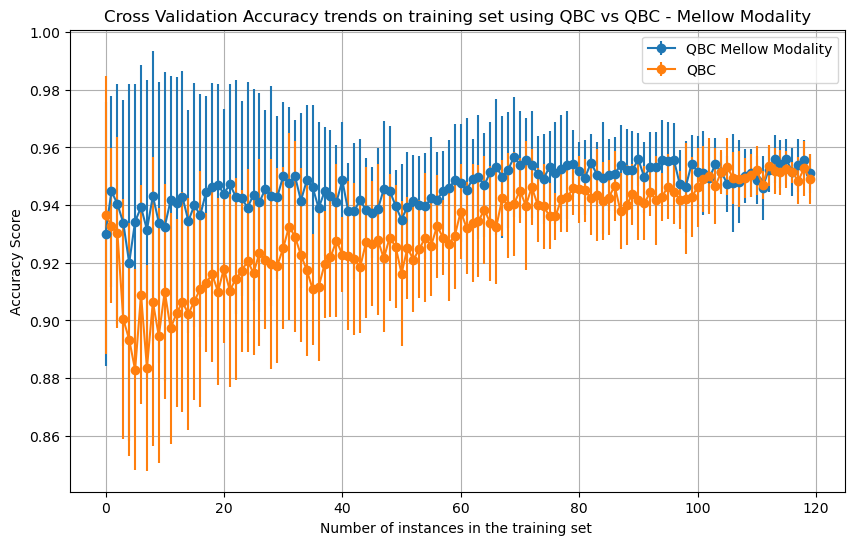

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
x_values_mellow_QBC = list(range(len(cv_acc)))

plt.errorbar(x_values_mellow_QBC, avg_acc_mellow_QBC, yerr=std_acc_mellow_QBC, fmt='-o', linestyle='-', label="QBC Mellow Modality")
plt.errorbar(x_values_QBC, avg_acc_QBC, yerr=std_acc_QBC, fmt='-o', linestyle='-', label="QBC")

plt.title('Cross Validation Accuracy trends on training set using QBC vs QBC - Mellow Modality')
plt.xlabel('Number of instances in the training set ')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()
